## Create ML model using RANDOM FOREST algorithm for self-driving car with LIDAR data

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 1. Loading the data

In [2]:
# read data from csv
data = pd.read_csv('../data/simulation/lidar_training_data_20250727_095526_half2.csv', header=None)
data.shape

(1553, 361)

In [3]:
# Take a look at the dataframe
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0.384499,0.385244,0.386111,0.387100,0.388214,0.389453,0.390821,0.392318,0.393949,0.393332,...,0.382730,0.382510,0.382407,0.382422,0.382553,0.382802,0.383168,0.383652,0.384256,-1.20
1549,0.372380,0.373104,0.373945,0.374905,0.375985,0.377187,0.378514,0.379966,0.381547,0.381802,...,0.370643,0.370432,0.370334,0.370350,0.370479,0.370721,0.371078,0.371549,0.372135,-1.20
1550,0.359481,0.360181,0.360994,0.361922,0.362966,0.364128,0.365410,0.366814,0.368341,0.369546,...,0.357794,0.357591,0.357498,0.357514,0.357640,0.357875,0.358221,0.358677,0.359244,-1.20
1551,0.347453,0.348130,0.348916,0.349813,0.350822,0.351945,0.353184,0.354541,0.356017,0.357615,...,0.345821,0.345625,0.345535,0.345550,0.345672,0.345899,0.346233,0.346674,0.347222,-1.20


## 2. Data Preprocessing

In [4]:
# Impute value of 0, Makeup data with 0 distance the average of 2 adjacent values
def cleanup_zero_distances(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - 1): # skip the last column as it is the Turn value
            if data.iloc[i, j] == 0:
                # get right side value
                k = j # set column position at j
                left_val = right_val = 0
                while k < data.shape[1]: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        right_val = data.iloc[i, k]
                        break
                    k = k + 1
                # get the left side value
                left_val = right_val
                k = j # set column position at j
                while k >= 0: # keep finding until found non zero value
                    if data.iloc[i, k] > 0:
                        left_val = data.iloc[i, k]
                        break
                    k = k - 1
                data.iat[i, j] = (left_val + right_val) / 2
cleanup_zero_distances(data)
data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0.384499,0.385244,0.386111,0.387100,0.388214,0.389453,0.390821,0.392318,0.393949,0.393332,...,0.382730,0.382510,0.382407,0.382422,0.382553,0.382802,0.383168,0.383652,0.384256,-1.20
1549,0.372380,0.373104,0.373945,0.374905,0.375985,0.377187,0.378514,0.379966,0.381547,0.381802,...,0.370643,0.370432,0.370334,0.370350,0.370479,0.370721,0.371078,0.371549,0.372135,-1.20
1550,0.359481,0.360181,0.360994,0.361922,0.362966,0.364128,0.365410,0.366814,0.368341,0.369546,...,0.357794,0.357591,0.357498,0.357514,0.357640,0.357875,0.358221,0.358677,0.359244,-1.20
1551,0.347453,0.348130,0.348916,0.349813,0.350822,0.351945,0.353184,0.354541,0.356017,0.357615,...,0.345821,0.345625,0.345535,0.345550,0.345672,0.345899,0.346233,0.346674,0.347222,-1.20


In [5]:
# get augmented data
def get_augmented_data(data):
    augmented_data = np.zeros(data.shape)
    for i in range(augmented_data.shape[0]):
        for j in range(augmented_data.shape[1]):
            augmented_data[i, j] = data.iloc[i, 359 - j]
        augmented_data[i, 360] = round(0 - float(data.iloc[i, 360]),2)
    
    return pd.DataFrame(augmented_data)
augmented_data = get_augmented_data(data)
augmented_data

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,1.880045,1.916747,1.955522,1.996521,2.039914,2.085887,2.134649,2.186523,2.241759,2.300580,...,1.643305,1.667311,1.692555,1.719108,1.747052,1.776471,1.807461,1.840124,1.874574,0.20
1,1.779696,1.814440,1.851144,1.889955,1.931032,1.974551,2.020710,2.069727,2.122052,2.177732,...,1.555639,1.578364,1.602261,1.627398,1.653851,1.681701,1.711038,1.741958,1.774570,0.15
2,1.679347,1.712132,1.746767,1.783389,1.822150,1.863215,1.906771,1.953009,2.002346,2.054885,...,1.467973,1.489418,1.511968,1.535689,1.560651,1.586931,1.614614,1.643793,1.674567,0.15
3,1.578998,1.609824,1.642389,1.676823,1.713268,1.751879,1.792833,1.836322,1.882639,1.932038,...,1.380307,1.400471,1.421675,1.443979,1.467450,1.492161,1.518191,1.545627,1.574563,0.25
4,1.478649,1.507516,1.538012,1.570258,1.604386,1.640544,1.678894,1.719620,1.762923,1.809190,...,1.292641,1.311525,1.331382,1.352269,1.374250,1.397391,1.421768,1.447461,1.474560,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0.384256,0.383652,0.383168,0.382802,0.382553,0.382422,0.382407,0.382510,0.382730,0.383068,...,0.393949,0.392318,0.390821,0.389453,0.388214,0.387100,0.386111,0.385244,0.384499,1.20
1549,0.372135,0.371549,0.371078,0.370721,0.370479,0.370350,0.370334,0.370432,0.370643,0.370968,...,0.381547,0.379966,0.378514,0.377187,0.375985,0.374905,0.373945,0.373104,0.372380,1.20
1550,0.359244,0.358677,0.358221,0.357875,0.357640,0.357514,0.357498,0.357591,0.357794,0.358106,...,0.368341,0.366814,0.365410,0.364128,0.362966,0.361922,0.360994,0.360181,0.359481,1.20
1551,0.347222,0.346674,0.346233,0.345899,0.345672,0.345550,0.345535,0.345625,0.345821,0.346123,...,0.356017,0.354541,0.353184,0.351945,0.350822,0.349813,0.348916,0.348130,0.347453,1.20


In [6]:
appended_df = pd.concat([data, augmented_data], ignore_index=True)
appended_df.rename(columns={appended_df.columns[-1]: 'Turn'}, inplace=True)
appended_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,Turn
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045,-0.20
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696,-0.15
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347,-0.15
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998,-0.25
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649,-0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,0.384256,0.383652,0.383168,0.382802,0.382553,0.382422,0.382407,0.382510,0.382730,0.383068,...,0.393949,0.392318,0.390821,0.389453,0.388214,0.387100,0.386111,0.385244,0.384499,1.20
3102,0.372135,0.371549,0.371078,0.370721,0.370479,0.370350,0.370334,0.370432,0.370643,0.370968,...,0.381547,0.379966,0.378514,0.377187,0.375985,0.374905,0.373945,0.373104,0.372380,1.20
3103,0.359244,0.358677,0.358221,0.357875,0.357640,0.357514,0.357498,0.357591,0.357794,0.358106,...,0.368341,0.366814,0.365410,0.364128,0.362966,0.361922,0.360994,0.360181,0.359481,1.20
3104,0.347222,0.346674,0.346233,0.345899,0.345672,0.345550,0.345535,0.345625,0.345821,0.346123,...,0.356017,0.354541,0.353184,0.351945,0.350822,0.349813,0.348916,0.348130,0.347453,1.20


In [7]:
X = appended_df.iloc[:, :-1]
X

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,1.874574,1.840124,1.807461,1.776471,1.747052,1.719108,1.692555,1.667311,1.643305,1.620469,...,2.300580,2.241759,2.186523,2.134649,2.085887,2.039914,1.996521,1.955522,1.916747,1.880045
1,1.774570,1.741958,1.711038,1.681701,1.653851,1.627398,1.602261,1.578364,1.555639,1.534021,...,2.177732,2.122052,2.069727,2.020710,1.974551,1.931032,1.889955,1.851144,1.814440,1.779696
2,1.674567,1.643793,1.614614,1.586931,1.560651,1.535689,1.511968,1.489418,1.467973,1.447574,...,2.054885,2.002346,1.953009,1.906771,1.863215,1.822150,1.783389,1.746767,1.712132,1.679347
3,1.574563,1.545627,1.518191,1.492161,1.467450,1.443979,1.421675,1.400471,1.380307,1.361126,...,1.932038,1.882639,1.836322,1.792833,1.751879,1.713268,1.676823,1.642389,1.609824,1.578998
4,1.474560,1.447461,1.421768,1.397391,1.374250,1.352269,1.331382,1.311525,1.292641,1.274678,...,1.809190,1.762923,1.719620,1.678894,1.640544,1.604386,1.570258,1.538012,1.507516,1.478649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,0.384256,0.383652,0.383168,0.382802,0.382553,0.382422,0.382407,0.382510,0.382730,0.383068,...,0.393332,0.393949,0.392318,0.390821,0.389453,0.388214,0.387100,0.386111,0.385244,0.384499
3102,0.372135,0.371549,0.371078,0.370721,0.370479,0.370350,0.370334,0.370432,0.370643,0.370968,...,0.381802,0.381547,0.379966,0.378514,0.377187,0.375985,0.374905,0.373945,0.373104,0.372380
3103,0.359244,0.358677,0.358221,0.357875,0.357640,0.357514,0.357498,0.357591,0.357794,0.358106,...,0.369546,0.368341,0.366814,0.365410,0.364128,0.362966,0.361922,0.360994,0.360181,0.359481
3104,0.347222,0.346674,0.346233,0.345899,0.345672,0.345550,0.345535,0.345625,0.345821,0.346123,...,0.357615,0.356017,0.354541,0.353184,0.351945,0.350822,0.349813,0.348916,0.348130,0.347453


In [8]:
# Assign target y as the last column 'Turn'
y = appended_df.iloc[:, -1]
y = appended_df.iloc[:, -1]
y

0      -0.20
1      -0.15
2      -0.15
3      -0.25
4      -0.30
        ... 
3101    1.20
3102    1.20
3103    1.20
3104    1.20
3105    1.20
Name: Turn, Length: 3106, dtype: float64

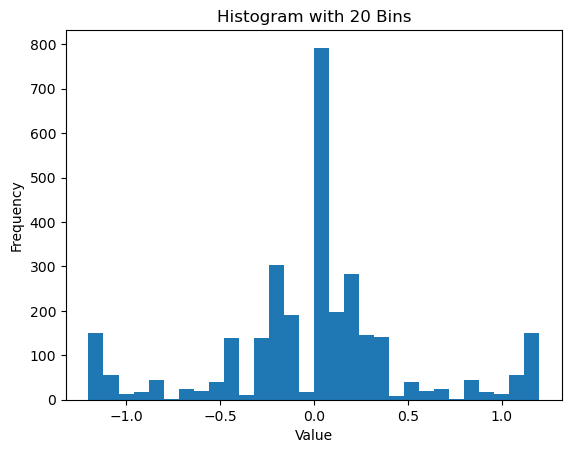

In [9]:
plt.hist(y, bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram with 20 Bins")
plt.show()

## 3. Model Training & Validation

In [10]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [11]:
y_train

2826    0.40
881    -0.70
2280    0.20
916    -0.30
2631    1.20
        ... 
1330   -1.20
3064    1.00
2213    0.00
2055    0.00
2267    0.15
Name: Turn, Length: 2329, dtype: float64

In [12]:
k = 30
k_best = SelectKBest(score_func=f_regression, k=k)
k_best.fit(X_train, y_train)

selected_feature_indices = k_best.get_support(indices=True)
print("selected_feature_indices: ", selected_feature_indices)

selected_feature_indices:  [ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77 282
 283 284 285 286 287 288 289 290 291 292 293 295]


In [13]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)

In [14]:
# Train the model on the training data
rf.fit(X_train.iloc[:, selected_feature_indices], y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [15]:
X_test.iloc[:, selected_feature_indices].shape

(777, 30)

In [16]:
# Make predictions on the testing data
y_pred = rf.predict(X_test.iloc[:, selected_feature_indices])

In [17]:
# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.027383718201248883


In [18]:
# Calculate the R-squared value of the predictions
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.907940659882627


## 4. Export the Model

In [19]:
import pickle
# Save the model to disk
filename = 'self_driving_model_0.2.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)